Jonathan Lam<br>
Prof. Keene<br>
ECE 475<br> 
Frequentist Machine Learning<br> 
9 / 10 / 20<br> 
Project 1

---

# Part 0: The model

The following classes define the regression techniques. `BaseLinearRegressionModel` includes some common utility functions for all of the regression techniques, including a `validate()` function and a `subsetSplit()` function. It is subclassed by `BasicLinearRegressionModel`, `RidgeRegressionModel`, and `LassoRegressionModel`, which implement different training techniques (overriding the `fit()` method).

## Part 0a: Base class

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn import linear_model


# base class for multi-input single-output regression
class BaseLinearRegressionModel:
  
    # features should be a ndarray NxP ndarray, labels a Nx1 ndarray,
    # featureNames should be an array of length P
    def __init__(self, features=None, labels=None, featureNames=None,
                 copySubsetsFrom=None):

        # if copySubsetsFrom is set, use this as a copy constructor,
        # don't redo subset split so that the same train/validate/test
        # subsets are available
        if copySubsetsFrom is not None:
            self._features = copySubsetsFrom._features
            self._labels = copySubsetsFrom._labels
            self._featureNames = copySubsetsFrom._featureNames
            self._subsets = copySubsetsFrom._subsets
            # don't copy validation data nor betas, these should be recalculated
            # with a new model
            return

        if features is None or labels is None or featureNames is None:
            raise Exception('missing parameters')

        self._features = features
        self._labels = labels
        self._featureNames = featureNames

        self._beta = None
        self._validationData = None

        self.subsetSplit()

    # this should be overridden using the regression strategy in subclasses
    def fit(self):
        raise Exception('cannot call fit() on abstract base regression class')

    # this very basic validation function performs a sweep and returns
    # the MSEs calculated for each beta on the validation data; the results are
    # stored in self._validationData so that they can be plotted later
    def validate(self, lbdas, betas):
        # calculate mses for all betas over the training set
        mses = np.array([self.mse(beta, subset='validation') for beta in betas])

        # store results of validation for use in graphing
        self._validationData = lbdas, mses, betas

        # return beta with minimum mse
        return betas[mses == np.min(mses), :].flatten()

    def plotValidation(self):
        lbdas, mses, betas = self._validationData
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=((15,15)))

        # plot coefficients vs. lambda
        ax1.plot(np.log(lbdas), betas[:, 1:])
        ax1.axvline(np.log(lbdas[mses == np.min(mses)]), ls='--')
        ax1.legend(list(self._featureNames) + ['optimal lambda'],
                   bbox_to_anchor=(1.05, 1), loc='upper left')
        ax1.set_title('coefficients vs. log(lambda)')
        ax1.set_ylabel('coefficients')
        ax1.set_xlabel('log(lambda)')
        ax1.grid('on')

        # plot mse vs. lambda
        ax2.plot(np.log(lbdas), mses)
        ax2.axvline(np.log(lbdas[mses == np.min(mses)]), ls='--')
        ax2.set_title('mse (on validation subset) vs. log(lambda)')
        ax2.set_ylabel('mse')
        ax2.set_xlabel('log(lambda)')
        ax2.grid('on')

        return fig

    # create a 80/10/10 train/validation/test subset split; this can be called
    # after fitting to create a new subset partitioning
    def subsetSplit(self):
        # N := total number of samples
        N, _ = self._features.shape

        # invalidate beta and validation data, since these were run on a
        # different subset partitioning
        self._beta = None
        self._validationData = None

        # splits (80/10/10)
        s1, s2 = 0.8, 0.9

        # randomly assign samples to datasets with given splits
        shufIndices = np.arange(N)
        np.random.shuffle(shufIndices)
        self._subsets = {
            'train': {
                'features': self._features[shufIndices[:int(s1 * N)]],
                'labels': self._labels[shufIndices[:int(s1 * N)]],
            },
            'validation': {
                'features': self._features[shufIndices[int(s1 * N):int(s2 * N)]],
                'labels': self._labels[shufIndices[int(s1 * N):int(s2 * N)]],
            },
            'test': {
                'features': self._features[shufIndices[int(s2 * N):]],
                'labels': self._labels[shufIndices[int(s2 * N):]],
            },
        }

    # normalize each feature in feature matrix X; z-score makes this easy
    # this is equivalent to sklearn.preprocessing.StandardScaler (I checked it
    # manually -- the output of this function matches that of StandardScaler)
    @staticmethod
    def _normalizeFeatures(X):
        result = np.zeros(X.shape)
        for i in range(X.shape[1]):
            # prevent error if stdev == 0; normalized is all zeros
            if np.std(X[:, i]) == 0:
                result[:, i] = np.zeros(X.shape[0])
                continue

            # feature = (feature - featureMean) / featureStdev (i.e., z-score)
            result[:, i] = stats.zscore(X[:, i])
        return result

    # helper function to get features and labels for a given subset;
    # returns the normalized augmented feature matrix X (with column of 1's)
    # and labels y for the given subset as a tuple; also returns
    # N, P, where N is number of training samples and P is number of features
    # (number of cols - 1, because of the column of 1's); default subset
    # is training subset
    def _subsetXy(self, subset='train'):
        # X := training feature set
        # Y := training label set
        X = self._subsets[subset]['features']
        y = self._subsets[subset]['labels']

        # N := number of training samples
        # P := number of features
        N, P = X.shape

        # scale down feature set
        X = self._normalizeFeatures(X)

        # augment X into Nx(P+1) matrix by adding a column of 1's at front
        X = np.insert(X, 0, [1] * N, axis=1)
        return X, y, N, P

    # compute and return mean-squared error of beta (on test subset)
    # uses the last computed beta by default, but can use a given beta
    # (i.e., when doing validation)
    def mse(self, beta, subset='test'):
        if beta is None and self._beta is None:
            return None

        # get test labels and normalized test subset features
        X, y, _, _ = self._subsetXy(subset)
        return np.mean((y - (X @ beta)) ** 2)

    # compute baseline mse (just a bias at the average value)
    def baselineMse(self):
        # get labels of training subset
        _, y, _, P = self._subsetXy()

        # run mse on test subset against the mean of the training subset labels
        baselineBeta = np.zeros(P + 1)
        baselineBeta[0] = np.mean(y)
        return self.mse(baselineBeta)

    # return correlation coefficient matrix of normalized features
    # this is performed on all subsets to get a sense of the population
    def corrCoef(self):
        return np.corrcoef(self._normalizeFeatures(self._features).T)

    # compute and return stderrs and z-scores for beta (on training subset)
    def zScores(self):
        beta = self._beta
        if beta is None:
            return None

        X, y, N, P = self._subsetXy()

        # estimate variance (eq. 3.8), calculate stderr and z-scores (eq. 3.12)
        variance = np.sum((y - (X @ beta)) ** 2) / (N - P - 1)
        stdErrs = np.sqrt(variance * np.diagonal(np.linalg.pinv(X.T @ X)))
        zScores = beta / stdErrs
        return stdErrs, zScores

    # beta getter
    def beta(self):
        return self._beta

## Part 0b: No regularization model

In [ ]:
# no regularization, basic linear regression; not to be confused with
# BaseLinearRegressionModel, which is the base class for the all of the
# linear regression models here
class BasicLinearRegressionModel(BaseLinearRegressionModel):

    def fit(self):
        # get normalized features matrix and labels for training subset
        X, y, _, _ = self._subsetXy()

        # compute beta (eq. 3.6)
        self._beta = np.linalg.pinv(X.T @ X) @ X.T @ y
        return self._beta

## Part 0c: Ridge regression model

Regression class with ridge regularization and validation. Validation works by performing a sweep on selected values in $\lambda\in[1,1000]$.

In [ ]:
# ridge regularization model; sweeps the parameter for lambda (rather than
# using DoF)
class RidgeLinearRegressionModel(BaseLinearRegressionModel):

    def fit(self):
        # get normalized features matrix and labels for training subset
        X, y, _, P = self._subsetXy()

        # column of 1's in X to avoid penalizing the bias
        X = X[:, 1:]

        # generate lambdas, beta candidates to sweep
        lbdas = np.hstack((np.linspace(0.0001, 0.01, 100),
                           np.linspace(0.01, 1, 100),
                           np.linspace(1, 100, 100),
                           np.linspace(100, 10000, 100)))
        betaCandidates = np.array([
            # eq. 3.44: ridge regression
            np.linalg.pinv(X.T @ X + lbda * np.eye(P)) @ X.T @ y
            for lbda in lbdas
        ])

        # reinsert column of biases, estimate bias with mean of y
        betaCandidates = np.insert(betaCandidates, 0,
                                   [np.mean(y)] * len(lbdas), axis=1)

        # choose best beta by validation
        self._beta = self.validate(lbdas, betaCandidates)
        return self._beta

## Part 0d: Lasso regression model

Regression class with lasso regularization and validation. Uses the `sklearn.linear_model.Lasso` function on the training inputs, and sweeps $\alpha\in [0.001,0.9]$. (Here, $\alpha$ is represented with the `lbda` variable to make it more consistent with the ridge regression parameters.)

In [ ]:
class LassoLinearRegressionModel(BaseLinearRegressionModel):

    def fit(self):
        # get normalized features matrix and labels for training subset
        X, y, _, P = self._subsetXy()

        # remove leading 1's from feature matrix, sklearn.linear_model.Lasso
        # will take care of intercepts
        X = X[:,1:]

        # generate lambdas and betas to sweep over
        lbdas = np.hstack((np.linspace(0.0001, 0.01, 100),
                           np.linspace(0.01, 1, 100)))
        betaCandidates = np.zeros((len(lbdas), P+1))
        for i, lbda in enumerate(lbdas):
            model = linear_model.Lasso(alpha=lbda, fit_intercept=True)
            model.fit(X, y)
            betaCandidates[i,:] = np.hstack((model.intercept_, model.coef_))

        # choose best beta by validation
        self._beta = self.validate(lbdas, betaCandidates)
        return self._beta

---

# Part 1: Prostate cancer dataset

Load prostate data file as a Pandas array and do some basic cleaning.

Features:
- lcaweight: log cancer volume
- lweight: log prostate weight
- age: patient age
- lbph: log of benign prostate hyperplasia
- svi: seminal vesicle invasion
- lcp: log of capsular penetration
- gleason: Gleason score
- pgg45: percent of Gleason scores 4 or 5

Target:
- lpsa: log of prostate-specific antigen


In [ ]:
# read in pandas dataframe from csv, drop first column (indices)
df = pd.read_csv('https://web.stanford.edu/~hastie/ElemStatLearn/datasets/prostate.data', '\t')
df = df.drop(df.columns[0], axis=1)

# ignore training label (67/30 split), we'll do our own 80/10/10 split and
# approximate the results rather than try to match the values in the textbook
df = df.drop('train', axis=1)

# get features and labels from the dataset
features = df.drop('lpsa', axis=1)
labels = df.loc[:, 'lpsa']

print('Prostate cancer dataset preview')
df

Prostate cancer dataset preview


,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa
0,-0.579818,2.769459,50,-1.386294,0,-1.386294,6,0,-0.430783
1,-0.994252,3.319626,58,-1.386294,0,-1.386294,6,0,-0.162519
2,-0.510826,2.691243,74,-1.386294,0,-1.386294,7,20,-0.162519
3,-1.203973,3.282789,58,-1.386294,0,-1.386294,6,0,-0.162519
4,0.751416,3.432373,62,-1.386294,0,-1.386294,6,0,0.371564
...,...,...,...,...,...,...,...,...,...
92,2.830268,3.876396,68,-1.386294,1,1.321756,7,60,4.385147
93,3.821004,3.896909,44,-1.386294,1,2.169054,7,40,4.684443
94,2.907447,3.396185,52,-1.386294,1,2.463853,7,10,5.143124
95,2.882564,3.773910,68,1.558145,1,1.558145,7,80,5.477509


Load data into model, print out feature correlation.

In [ ]:
# create the basic linear regression model, run fit, get values
basicReg = BasicLinearRegressionModel(features.to_numpy(),
                                      labels.to_numpy(), features.columns)
print(f'baseline mse: {basicReg.baselineMse()}\n')
print('Feature correlation')
pd.DataFrame(data=np.around(basicReg.corrCoef(), 2),
              index=features.columns,
              columns=features.columns)

baseline mse: 0.8808019334148127

Feature correlation


,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45
lcavol,1.00,0.28,0.22,0.03,0.54,0.68,0.43,0.43
lweight,0.28,1.00,0.35,0.44,0.16,0.16,0.06,0.11
age,0.22,0.35,1.00,0.35,0.12,0.13,0.27,0.28
lbph,0.03,0.44,0.35,1.00,-0.09,-0.01,0.08,0.08
svi,0.54,0.16,0.12,-0.09,1.00,0.67,0.32,0.46
lcp,0.68,0.16,0.13,-0.01,0.67,1.00,0.51,0.63
gleason,0.43,0.06,0.27,0.08,0.32,0.51,1.00,0.75
pgg45,0.43,0.11,0.28,0.08,0.46,0.63,0.75,1.00


## Part 1a: No regularization

In [ ]:
basicReg.fit()
print(f'mse: {basicReg.mse(basicReg.beta())}\n')
pd.DataFrame(data=np.around(np.vstack((basicReg.beta(),
                                       basicReg.zScores())),2).T,
             columns=['beta', 'stderr', 'zscore'],
             index=np.hstack((['bias'],features.columns)))

mse: 0.4957672668104931



,beta,stderr,zscore
bias,2.43,0.08,29.83
lcavol,0.62,0.11,5.40
lweight,0.31,0.10,3.00
age,-0.16,0.10,-1.60
lbph,0.13,0.10,1.31
svi,0.31,0.11,2.85
lcp,-0.14,0.14,-1.05
gleason,0.15,0.13,1.13
pgg45,0.00,0.14,0.01


## Part 1b: Ridge regularization

Run the linear regression with ridge regularization. This uses the same subset partitioning as the basic linear regression without regularization.

In [ ]:
# create ridge reg. with same training/validation/test data as first regression
ridgeReg = RidgeLinearRegressionModel(copySubsetsFrom=basicReg)
ridgeReg.fit()
print(f'mse: {ridgeReg.mse(ridgeReg.beta())}\n')
pd.DataFrame(data=np.around(np.vstack((ridgeReg.beta(),
                                       ridgeReg.zScores())),2).T,
             columns=['beta', 'stderr', 'zscore'],
             index=np.hstack((['bias'],features.columns)))

mse: 0.4820368716805007



,beta,stderr,zscore
bias,2.43,0.08,29.77
lcavol,0.58,0.11,5.04
lweight,0.29,0.10,2.88
age,-0.14,0.10,-1.39
lbph,0.12,0.10,1.22
svi,0.30,0.11,2.70
lcp,-0.10,0.14,-0.70
gleason,0.14,0.13,1.05
pgg45,-0.00,0.14,-0.01


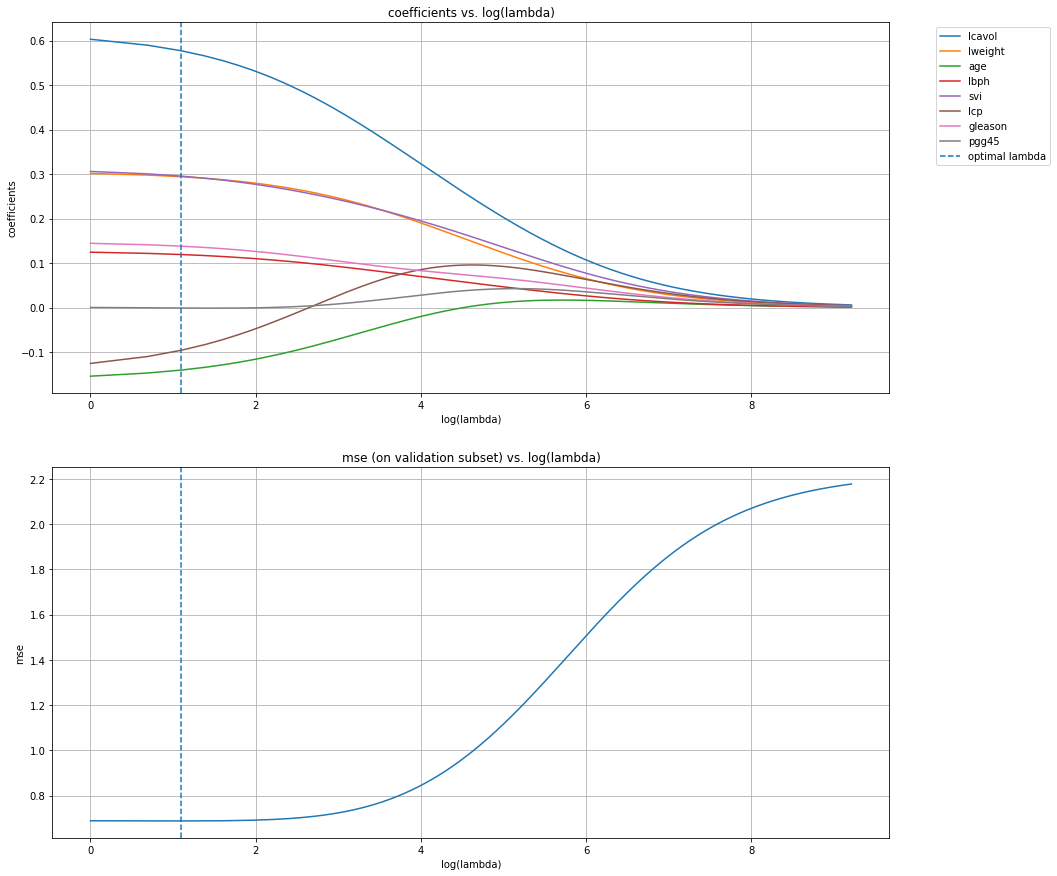

In [ ]:
ridgeReg.plotValidation().show()

## Part 1c: Lasso regularization

Run the linear regression with lasso regularization. This uses the same subset partitioning as the basic linear regression without regularization.

In [ ]:
# create lasso reg. with same training/validation/test data as first regression
lassoReg = LassoLinearRegressionModel(copySubsetsFrom=basicReg)
lassoReg.fit()
print(f'mse: {lassoReg.mse(lassoReg.beta())}\n')
pd.DataFrame(data=np.around(np.vstack((lassoReg.beta(),
                                       lassoReg.zScores())),2).T,
             columns=['beta', 'stderr', 'zscore'],
             index=np.hstack((['bias'],features.columns)))

mse: 0.4488124977580511



,beta,stderr,zscore
bias,2.43,0.08,29.35
lcavol,0.55,0.12,4.76
lweight,0.26,0.10,2.54
age,-0.07,0.10,-0.68
lbph,0.08,0.10,0.80
svi,0.25,0.11,2.21
lcp,-0.00,0.14,-0.00
gleason,0.08,0.13,0.59
pgg45,0.00,0.14,0.00


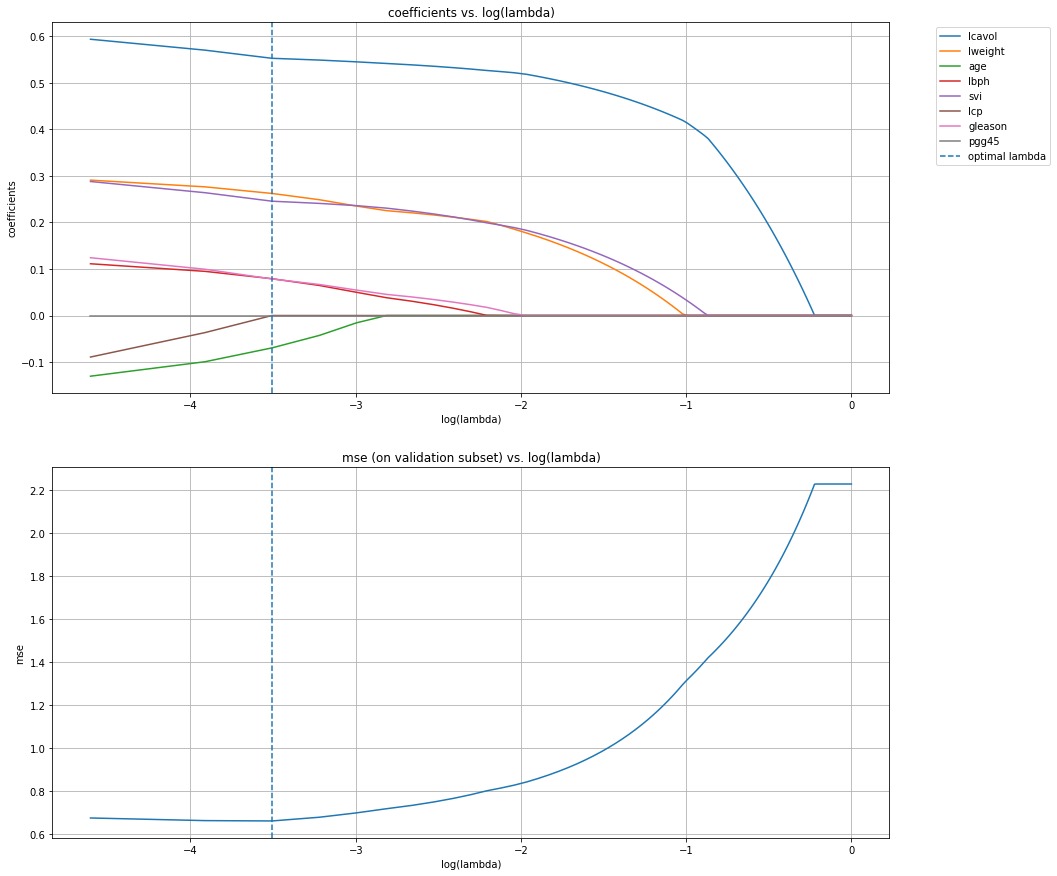

In [ ]:
lassoReg.plotValidation().show()

---

# Part 2: Red Wine dataset

Attribute information:

> For more information, read [Cortez et al., 2009].<br>
Input variables (based on physicochemical tests):<br>
1 - fixed acidity<br>
2 - volatile acidity<br>
3 - citric acid<br>
4 - residual sugar<br>
5 - chlorides<br>
6 - free sulfur dioxide<br>
7 - total sulfur dioxide<br>
8 - density<br>
9 - pH<br>
10 - sulphates<br>
11 - alcohol<br>
Output variable (based on sensory data):<br>
12 - quality (score between 0 and 10)<br>

Dataset source: [UCI "Wine Quality" dataset](https://archive.ics.uci.edu/ml/datasets/Wine+Quality).

The features are all quantitative and there is no missing data, so no data cleaning needs to be performed.

In [ ]:
df2 = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv',';')
features2 = df2.drop(['quality'], axis=1)
labels2 = df2.loc[:, 'quality']

print('Red wine dataset preview')
df2

Red wine dataset preview


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [ ]:
basicReg2 = BasicLinearRegressionModel(features2.to_numpy(),
                                       labels2.to_numpy(), features2.columns)
print(f'baseline mse: {basicReg2.baselineMse()}\n')
print('Feature correlation')
pd.DataFrame(data=np.around(basicReg2.corrCoef(), 2),
              index=features2.columns,
              columns=features2.columns)

baseline mse: 0.5645694630468364

Feature correlation


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
fixed acidity,1.00,-0.26,0.67,0.11,0.09,-0.15,-0.11,0.67,-0.68,0.18,-0.06
volatile acidity,-0.26,1.00,-0.55,0.00,0.06,-0.01,0.08,0.02,0.23,-0.26,-0.20
citric acid,0.67,-0.55,1.00,0.14,0.20,-0.06,0.04,0.36,-0.54,0.31,0.11
residual sugar,0.11,0.00,0.14,1.00,0.06,0.19,0.20,0.36,-0.09,0.01,0.04
chlorides,0.09,0.06,0.20,0.06,1.00,0.01,0.05,0.20,-0.27,0.37,-0.22
free sulfur dioxide,-0.15,-0.01,-0.06,0.19,0.01,1.00,0.67,-0.02,0.07,0.05,-0.07
total sulfur dioxide,-0.11,0.08,0.04,0.20,0.05,0.67,1.00,0.07,-0.07,0.04,-0.21
density,0.67,0.02,0.36,0.36,0.20,-0.02,0.07,1.00,-0.34,0.15,-0.50
pH,-0.68,0.23,-0.54,-0.09,-0.27,0.07,-0.07,-0.34,1.00,-0.20,0.21
sulphates,0.18,-0.26,0.31,0.01,0.37,0.05,0.04,0.15,-0.20,1.00,0.09


## Part 2a: No regularization

In [ ]:
basicReg2.fit()
print(f'mse: {basicReg2.mse(basicReg2.beta(), "test")}\n')
pd.DataFrame(data=np.around(np.vstack((basicReg2.beta(),
                                       basicReg2.zScores())),2).T,
             columns=['beta', 'stderr', 'zscore'],
             index=np.hstack((['bias'],features2.columns)))

mse: 0.4360136340429069



,beta,stderr,zscore
bias,5.62,0.02,314.70
fixed acidity,0.07,0.05,1.32
volatile acidity,-0.21,0.02,-8.60
citric acid,-0.05,0.03,-1.68
residual sugar,0.03,0.02,1.11
chlorides,-0.09,0.02,-3.90
free sulfur dioxide,0.04,0.02,1.46
total sulfur dioxide,-0.09,0.03,-3.54
density,-0.04,0.04,-0.91
pH,-0.08,0.03,-2.43


## Part 2b: Ridge regularization

In [ ]:
ridgeReg2 = RidgeLinearRegressionModel(copySubsetsFrom=basicReg2)
ridgeReg2.fit()
print(f'mse: {ridgeReg2.mse(ridgeReg2.beta())}\n')
pd.DataFrame(data=np.around(np.vstack((ridgeReg2.beta(),
                                       ridgeReg2.zScores())),2).T,
             columns=['beta', 'stderr', 'zscore'],
             index=np.hstack((['bias'],features2.columns)))

mse: 0.4164360004441642



,beta,stderr,zscore
bias,5.62,0.02,311.84
fixed acidity,0.06,0.05,1.18
volatile acidity,-0.16,0.02,-6.70
citric acid,0.02,0.03,0.47
residual sugar,0.03,0.02,1.15
chlorides,-0.08,0.02,-3.38
free sulfur dioxide,0.02,0.03,0.70
total sulfur dioxide,-0.08,0.03,-2.91
density,-0.07,0.05,-1.54
pH,-0.04,0.03,-1.19


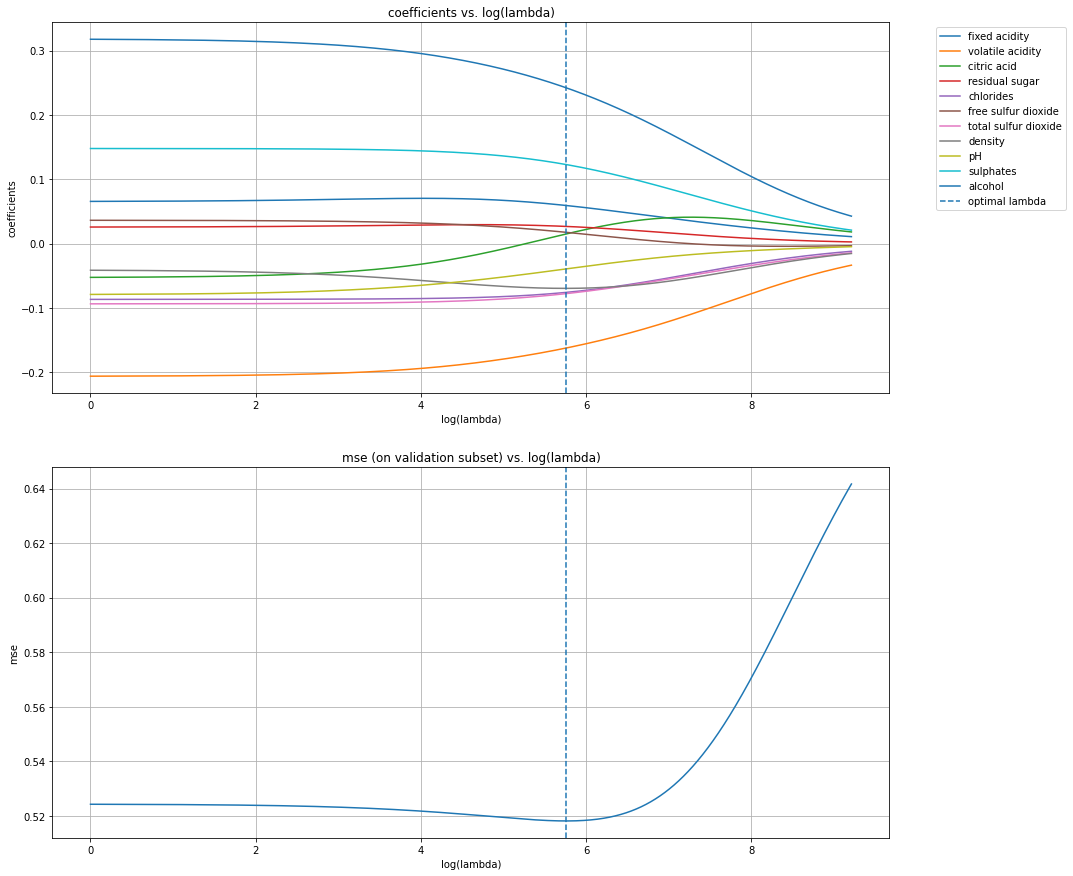

In [ ]:
ridgeReg2.plotValidation().show()

## Part 2c: Lasso regularization

In [ ]:
lassoReg2 = LassoLinearRegressionModel(copySubsetsFrom=basicReg2)
lassoReg2.fit()
print(f'mse: {lassoReg2.mse(lassoReg2.beta())}\n')
pd.DataFrame(data=np.around(np.vstack((lassoReg2.beta(),
                                       lassoReg2.zScores())),2).T,
             columns=['beta', 'stderr', 'zscore'],
             index=np.hstack((['bias'],features2.columns)))

mse: 0.4218980815804822



,beta,stderr,zscore
bias,5.62,0.02,311.62
fixed acidity,0.01,0.05,0.23
volatile acidity,-0.19,0.02,-7.84
citric acid,0.00,0.03,0.00
residual sugar,0.00,0.02,0.00
chlorides,-0.04,0.02,-1.96
free sulfur dioxide,0.00,0.03,0.00
total sulfur dioxide,-0.04,0.03,-1.60
density,-0.00,0.05,-0.00
pH,-0.04,0.03,-1.23


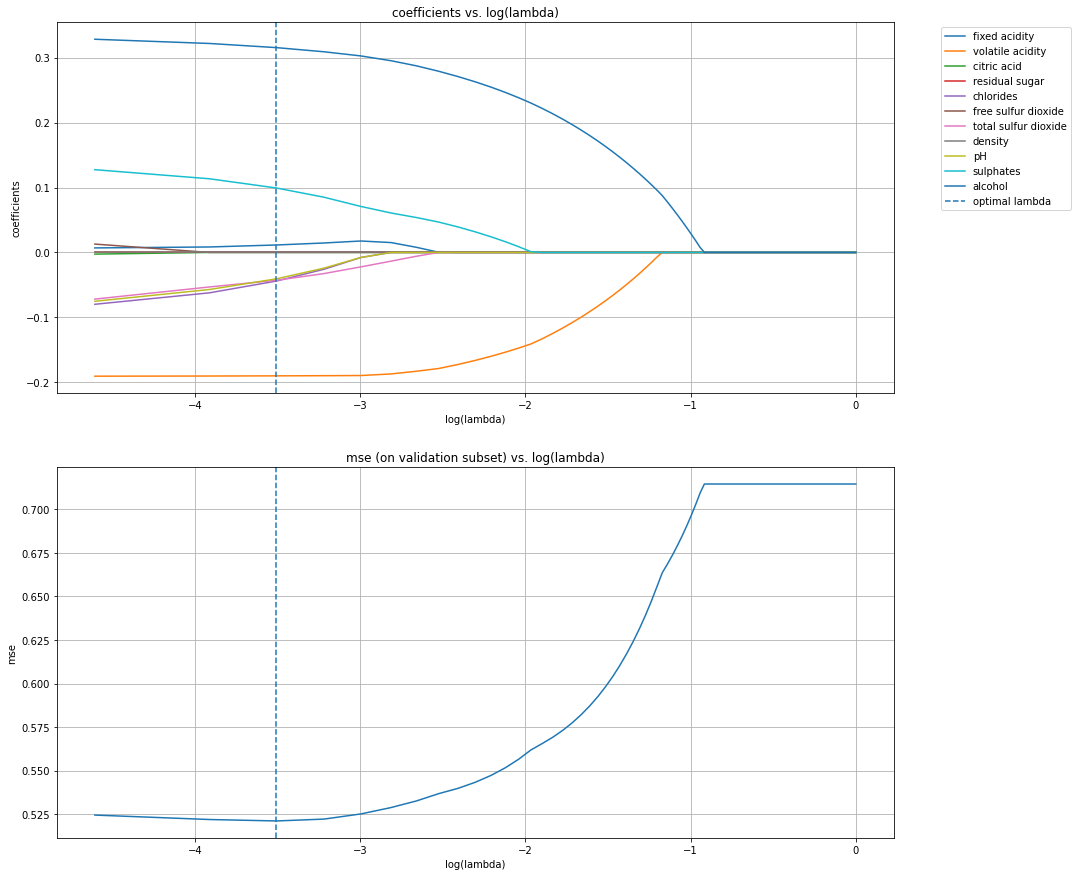

In [ ]:
lassoReg2.plotValidation().show()

---

# Part 3: Feature engineering

As a basic form of feature engineering, I'll try to add some powers (nonlinear terms) of the original features of the red wine dataset and see if this improves the results.

(I also messed around somewhat with interaction terms by summing/multiplying arbitrary features, but was unable to get any sort of consistent and significant results from this. I wasn't sure of a systematic way of displaying any interaction terms, so I left them out.)

In [ ]:
features3 = features2.copy()
labels3 = labels2.copy()

features3Squared = features3 ** 2
features3Squared.columns = [f'({name})^2' for name in features3Squared.columns]
features3Cubed = features3 ** 3
features3Cubed.columns = [f'({name})^3' for name in features3Cubed.columns]

features3All = pd.concat([features3, features3Squared, features3Cubed], axis=1)
print('Preview of engineered features')
features3All

Preview of engineered features


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,(fixed acidity)^2,(volatile acidity)^2,(citric acid)^2,(residual sugar)^2,(chlorides)^2,(free sulfur dioxide)^2,(total sulfur dioxide)^2,(density)^2,(pH)^2,(sulphates)^2,(alcohol)^2,(fixed acidity)^3,(volatile acidity)^3,(citric acid)^3,(residual sugar)^3,(chlorides)^3,(free sulfur dioxide)^3,(total sulfur dioxide)^3,(density)^3,(pH)^3,(sulphates)^3,(alcohol)^3
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,54.76,0.490000,0.0000,3.61,0.005776,121.0,1156.0,0.995605,12.3201,0.3136,88.36,405.224,0.343000,0.000000,6.859,0.000439,1331.0,39304.0,0.993415,43.243551,0.175616,830.584
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,60.84,0.774400,0.0000,6.76,0.009604,625.0,4489.0,0.993610,10.2400,0.4624,96.04,474.552,0.681472,0.000000,17.576,0.000941,15625.0,300763.0,0.990431,32.768000,0.314432,941.192
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,60.84,0.577600,0.0016,5.29,0.008464,225.0,2916.0,0.994009,10.6276,0.4225,96.04,474.552,0.438976,0.000064,12.167,0.000779,3375.0,157464.0,0.991027,34.645976,0.274625,941.192
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,125.44,0.078400,0.3136,3.61,0.005625,289.0,3600.0,0.996004,9.9856,0.3364,96.04,1404.928,0.021952,0.175616,6.859,0.000422,4913.0,216000.0,0.994012,31.554496,0.195112,941.192
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,54.76,0.490000,0.0000,3.61,0.005776,121.0,1156.0,0.995605,12.3201,0.3136,88.36,405.224,0.343000,0.000000,6.859,0.000439,1331.0,39304.0,0.993415,43.243551,0.175616,830.584
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,38.44,0.360000,0.0064,4.00,0.008100,1024.0,1936.0,0.989826,11.9025,0.3364,110.25,238.328,0.216000,0.000512,8.000,0.000729,32768.0,85184.0,0.984778,41.063625,0.195112,1157.625
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,34.81,0.302500,0.0100,4.84,0.003844,1521.0,2601.0,0.990264,12.3904,0.5776,125.44,205.379,0.166375,0.001000,10.648,0.000238,59319.0,132651.0,0.985431,43.614208,0.438976,1404.928
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,39.69,0.260100,0.0169,5.29,0.005776,841.0,1600.0,0.991498,11.6964,0.5625,121.00,250.047,0.132651,0.002197,12.167,0.000439,24389.0,64000.0,0.987274,40.001688,0.421875,1331.000
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,34.81,0.416025,0.0144,4.00,0.005625,1024.0,1936.0,0.990961,12.7449,0.5041,104.04,205.379,0.268336,0.001728,8.000,0.000422,32768.0,85184.0,0.986471,45.499293,0.357911,1061.208


In [ ]:
basicReg3 = BasicLinearRegressionModel(features3All.to_numpy(),
                                       labels3.to_numpy(), features3All.columns)
print(f'baseline mse: {basicReg3.baselineMse()}\n')
print('Feature correlation')
pd.DataFrame(data=np.around(basicReg3.corrCoef(), 2),
              index=features3All.columns,
              columns=features3All.columns)

baseline mse: 0.6722580082660844

Feature correlation


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,(fixed acidity)^2,(volatile acidity)^2,(citric acid)^2,(residual sugar)^2,(chlorides)^2,(free sulfur dioxide)^2,(total sulfur dioxide)^2,(density)^2,(pH)^2,(sulphates)^2,(alcohol)^2,(fixed acidity)^3,(volatile acidity)^3,(citric acid)^3,(residual sugar)^3,(chlorides)^3,(free sulfur dioxide)^3,(total sulfur dioxide)^3,(density)^3,(pH)^3,(sulphates)^3,(alcohol)^3
fixed acidity,1.00,-0.26,0.67,0.11,0.09,-0.15,-0.11,0.67,-0.68,0.18,-0.06,0.99,-0.22,0.66,0.06,0.03,-0.11,-0.09,0.67,-0.68,0.15,-0.07,0.96,-0.18,0.60,0.03,0.01,-0.09,-0.05,0.67,-0.68,0.10,-0.07
volatile acidity,-0.26,1.00,-0.55,0.00,0.06,-0.01,0.08,0.02,0.23,-0.26,-0.20,-0.25,0.97,-0.47,-0.02,0.02,-0.02,0.05,0.02,0.24,-0.20,-0.20,-0.24,0.88,-0.37,-0.03,0.00,-0.02,0.01,0.02,0.24,-0.13,-0.20
citric acid,0.67,-0.55,1.00,0.14,0.20,-0.06,0.04,0.36,-0.54,0.31,0.11,0.66,-0.49,0.95,0.10,0.20,-0.04,0.07,0.37,-0.54,0.27,0.11,0.63,-0.40,0.85,0.08,0.19,-0.03,0.09,0.37,-0.53,0.21,0.11
residual sugar,0.11,0.00,0.14,1.00,0.06,0.19,0.20,0.36,-0.09,0.01,0.04,0.12,-0.00,0.15,0.93,0.01,0.26,0.23,0.36,-0.09,-0.01,0.04,0.12,-0.01,0.15,0.81,-0.01,0.31,0.22,0.36,-0.09,-0.01,0.05
chlorides,0.09,0.06,0.20,0.06,1.00,0.01,0.05,0.20,-0.27,0.37,-0.22,0.08,0.05,0.25,0.07,0.94,0.03,0.02,0.20,-0.26,0.41,-0.22,0.06,0.04,0.29,0.07,0.84,0.04,-0.01,0.20,-0.25,0.40,-0.21
free sulfur dioxide,-0.15,-0.01,-0.06,0.19,0.01,1.00,0.67,-0.02,0.07,0.05,-0.07,-0.15,-0.02,-0.09,0.20,0.01,0.94,0.53,-0.02,0.07,0.05,-0.07,-0.15,-0.03,-0.09,0.19,0.01,0.80,0.34,-0.02,0.07,0.05,-0.07
total sulfur dioxide,-0.11,0.08,0.04,0.20,0.05,0.67,1.00,0.07,-0.07,0.04,-0.21,-0.12,0.05,-0.02,0.18,0.03,0.57,0.92,0.07,-0.07,0.08,-0.20,-0.12,0.03,-0.04,0.14,0.02,0.45,0.70,0.07,-0.06,0.11,-0.19
density,0.67,0.02,0.36,0.36,0.20,-0.02,0.07,1.00,-0.34,0.15,-0.50,0.65,-0.00,0.37,0.28,0.09,0.01,0.03,1.00,-0.34,0.12,-0.50,0.63,-0.02,0.35,0.22,0.05,0.03,-0.02,1.00,-0.34,0.09,-0.50
pH,-0.68,0.23,-0.54,-0.09,-0.27,0.07,-0.07,-0.34,1.00,-0.20,0.21,-0.65,0.23,-0.50,-0.07,-0.23,0.04,-0.11,-0.34,1.00,-0.23,0.20,-0.61,0.20,-0.46,-0.06,-0.19,0.02,-0.11,-0.34,1.00,-0.24,0.20
sulphates,0.18,-0.26,0.31,0.01,0.37,0.05,0.04,0.15,-0.20,1.00,0.09,0.18,-0.25,0.31,0.00,0.40,0.04,0.02,0.15,-0.19,0.96,0.09,0.17,-0.22,0.30,0.00,0.38,0.02,-0.00,0.15,-0.18,0.86,0.09


## Part 3a: No regularization

In [ ]:
basicReg3.fit()
print(f'mse: {basicReg3.mse(basicReg3.beta(), "test")}\n')
pd.DataFrame(data=np.around(np.vstack((basicReg3.beta(),
                                       basicReg3.zScores())),2).T,
             columns=['beta', 'stderr', 'zscore'],
             index=np.hstack((['bias'],features3All.columns)))

mse: 0.3875555114427124



,beta,stderr,zscore
bias,5.61,0.02,315.19
fixed acidity,0.19,0.78,0.24
volatile acidity,-0.42,0.26,-1.60
citric acid,0.00,0.13,0.02
residual sugar,-0.07,0.16,-0.44
chlorides,-0.18,0.13,-1.40
free sulfur dioxide,0.28,0.15,1.85
total sulfur dioxide,0.09,0.14,0.67
density,-1701.64,5690.80,-0.30
pH,4.42,8.40,0.53


## Part 3b: Ridge regularization

In [ ]:
ridgeReg3 = RidgeLinearRegressionModel(copySubsetsFrom=basicReg3)
ridgeReg3.fit()
print(f'mse: {ridgeReg3.mse(ridgeReg3.beta())}\n')
pd.DataFrame(data=np.around(np.vstack((ridgeReg3.beta(),
                                       ridgeReg3.zScores())),2).T,
             columns=['beta', 'stderr', 'zscore'],
             index=np.hstack((['bias'],features3All.columns)))

mse: 0.3878974791375196



,beta,stderr,zscore
bias,5.61,0.02,315.18
fixed acidity,0.13,0.78,0.16
volatile acidity,-0.43,0.26,-1.63
citric acid,0.00,0.13,0.01
residual sugar,-0.07,0.16,-0.44
chlorides,-0.18,0.13,-1.42
free sulfur dioxide,0.28,0.15,1.86
total sulfur dioxide,0.09,0.14,0.66
density,-5.35,5691.01,-0.00
pH,3.62,8.40,0.43


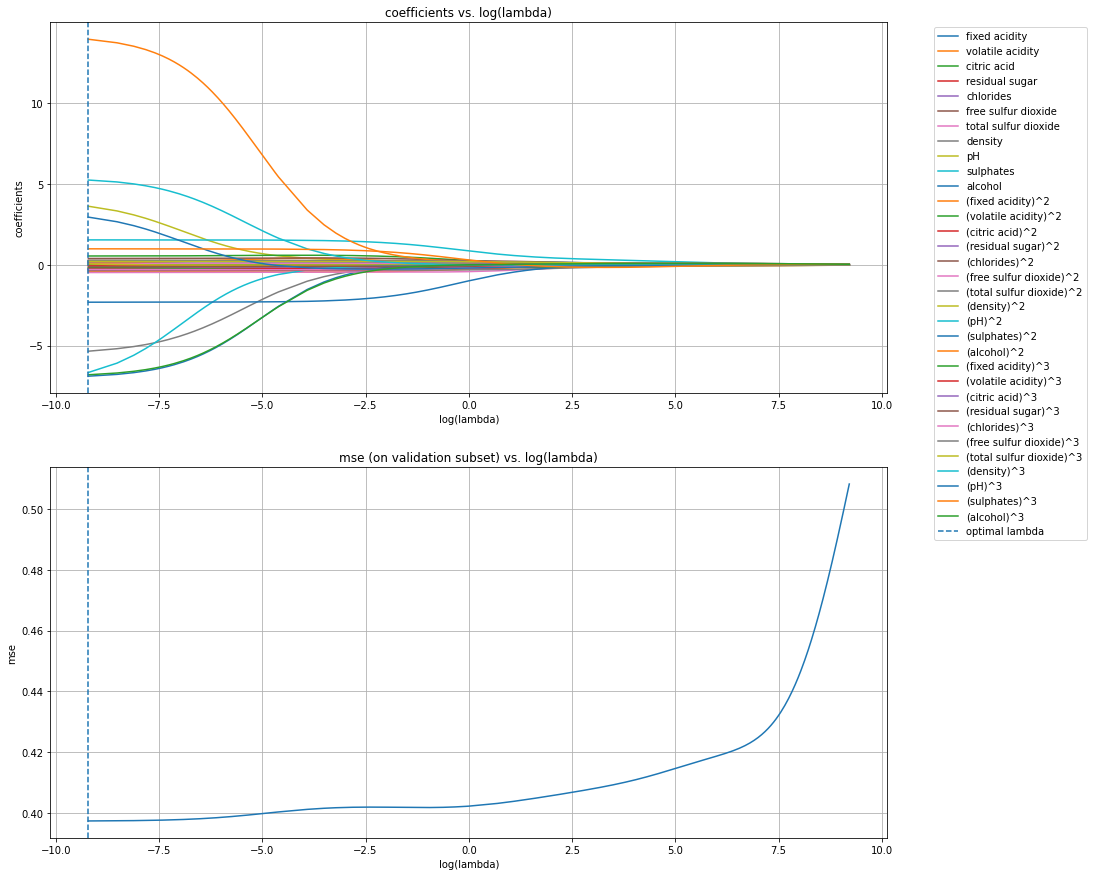

In [ ]:
ridgeReg3.plotValidation().show()

## Part 3c: Lasso regularization

In [ ]:
lassoReg3 = LassoLinearRegressionModel(copySubsetsFrom=basicReg3)
lassoReg3.fit()
print(f'mse: {lassoReg3.mse(lassoReg3.beta())}\n')
pd.DataFrame(data=np.around(np.vstack((lassoReg3.beta(),
                                       lassoReg3.zScores())),2).T,
             columns=['beta', 'stderr', 'zscore'],
             index=np.hstack((['bias'],features3All.columns)))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 167.93274436154616, tolerance: 0.08329695074276783
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 113.00987914063819, tolerance: 0.08329695074276783
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 61.944968997659885, tolerance: 0.08329695074276783
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28.

mse: 0.3932675740271798



,beta,stderr,zscore
bias,5.61,0.02,313.49
fixed acidity,0.18,0.79,0.23
volatile acidity,-0.17,0.27,-0.62
citric acid,-0.01,0.13,-0.10
residual sugar,0.00,0.16,0.00
chlorides,-0.05,0.13,-0.38
free sulfur dioxide,0.25,0.15,1.69
total sulfur dioxide,0.03,0.14,0.21
density,-0.00,5721.67,-0.00
pH,0.00,8.44,0.00


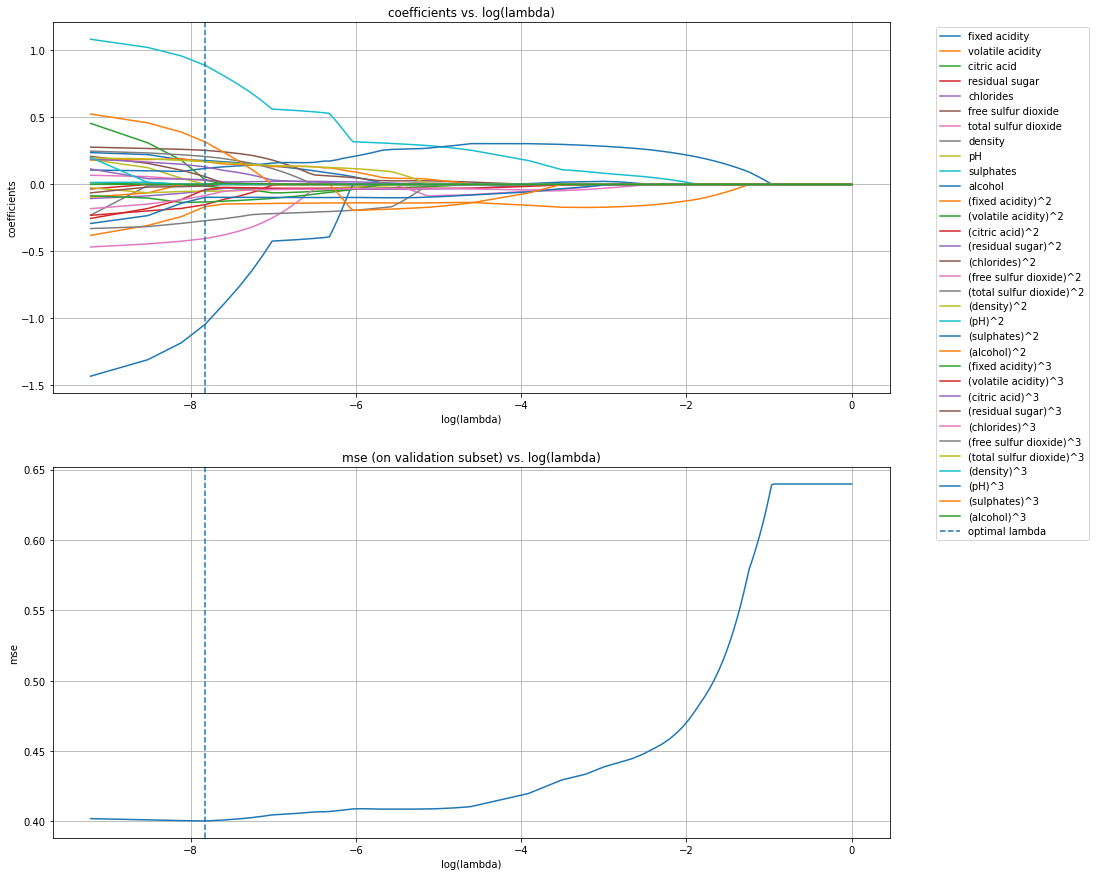

In [ ]:
lassoReg3.plotValidation().show()

---

# Answers to questions

*Which features did the Lasso select for you to include in your model? Do these features make sense?*

- In the prostate cancer dataset, mostly only the lcp and age features were suppressed with the Lasso. I don't know much about prostate cancer, so I can't interpret the results of this too much.
- In the red wine dataset, there were a few coefficients that were very low even in the no-regularization case, such as fixed acidity, density, and pH. The factors that were most severely suppressed were the total and fixed sulfur concentrations, as well as the sulfates feature. I don't know much about wine either, but it makes sense that people are not looking for the amount of sulfur in their wine when considering whether it's good or not.

*Compute the MSE on the training dataset and the test dataset for all methods and comment on the results. Compare this MSE to a baseline MSE.*

In both datasets, the baseline MSE was higher than the MSE calculated for any of the regression methods, as expected. See the chart following this section.

*Stretch goal: Add nonlinear and interaction terms to your dataset and try to improve the performance. Are you able to do so?*

I tried adding arbitrary interaction terms, but without knowing much about what makes quality wine I was unable to find a combination that consistently produced significant results (and I wasn't able to find a way to do this systematically). The above example shows adding nonlinear terms (squared and cubed values of the original sample dataset). When doing this:

- The baseline MSE stayed around the same value ($\approx$0.5 to 0.7).
- The regression MSEs were a little lower than without these extra features ($\approx$0.3 to 0.4, rather than $\approx 0.4$ to 0.5 without the extra features).
- The regularized models don't seem to outperform the no-regularization model by any significant amount.

Thus, even by this very basic feature engineering (adding powers of features), there seems to be a small but noticeable improvement in overall MSEs.


In [ ]:
print('MSE summary')
mses = [[basicReg.baselineMse(), basicReg.mse(basicReg.beta()),
         ridgeReg.mse(ridgeReg.beta()), lassoReg.mse(lassoReg.beta())],
        [basicReg2.baselineMse(), basicReg2.mse(basicReg2.beta()),
         ridgeReg2.mse(ridgeReg2.beta()), lassoReg2.mse(lassoReg2.beta())],
        [basicReg3.baselineMse(), basicReg3.mse(basicReg3.beta()),
         ridgeReg3.mse(ridgeReg3.beta()), lassoReg3.mse(lassoReg3.beta())]]
pd.DataFrame(data=mses,
             columns=['baseline','no reg.','ridge','lasso'],
             index=['prostate cancer', 'red wine', 'red wine feature eng.'])

MSE summary


,baseline,no reg.,ridge,lasso
prostate cancer,0.880802,0.495767,0.482037,0.448812
red wine,0.564569,0.436014,0.416436,0.421898
red wine feature eng.,0.672258,0.387556,0.387897,0.393268


---

# Other comments

- There was a lot of variation between runs, so there were often runs where ridge and/or lasso did worse than the no-regularization case. Given the small number of samples (small training set, validation set, and testing set all are not helpful) and a single validation (rather than k-fold cross validation), this is somewhat expected.
- There were even some times that the baseline performed better than the regressions, which made me very skeptical; however, I verified the numbers in some of these cases and conclude that this is due to the wide variation between randomly-selected train and test datasets (again due to the small size), not due to a problem in the model.
- On some runs, the validation gave a minimum MSE when $\lambda=0$ (or $\alpha=0$). Again, this is probably due to the small sample size.